<a href="https://colab.research.google.com/github/armiro/Covid19-Detection/blob/master/unet_lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

import tensorflow as tf, cv2, numpy as np

%matplotlib inline
import matplotlib.pyplot as plt, matplotlib.cm as cm

from skimage.filters import rank
from skimage.morphology import disk

In [0]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
segmentor.load_weights('/content/drive/My Drive/cxr_reg_weights.hdf5')

number of total dataset images: 5428
number of total dataset labels: 5428
dataset shape: (5428, 320, 320, 1)


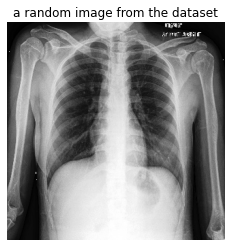

In [3]:
X = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_samples.npy')
y = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_labels.npy')

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

image index: 413
which enhancement method works best?


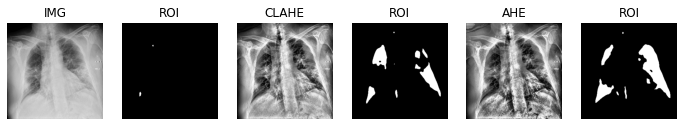

In [0]:
# IMG_IDX = np.random.choice(a=len(X), size=None)
IMG_IDX = 413
print('image index:', IMG_IDX)
test_img = np.expand_dims(X[IMG_IDX], axis=0)
test_img_sq = test_img.squeeze()

test_img_clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8)).apply(test_img_sq)
test_img_clahe = np.expand_dims(a=test_img_clahe, axis=-1)

test_img_ahe = np.expand_dims(rank.equalize(test_img_sq, selem=disk(40)), axis=-1)

roi = segmentor(test_img)
roi_sq = np.squeeze(roi)

roi_clahe = segmentor(np.expand_dims(test_img_clahe, axis=0))
roi_clahe_sq = np.squeeze(roi_clahe)

roi_ahe = segmentor(np.expand_dims(test_img_ahe, axis=0))
roi_ahe_sq = np.squeeze(roi_ahe)

images = [test_img_sq, roi_sq, test_img_clahe.squeeze(), roi_clahe_sq, 
          test_img_ahe.squeeze(), roi_ahe_sq]
titles = ['IMG', 'ROI', 'CLAHE', 'ROI', 'AHE', 'ROI']
fig = plt.figure(num=6, figsize=(12, 2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
print('which enhancement method works best?')
plt.show()

image index: 413
How much dilation do we need?


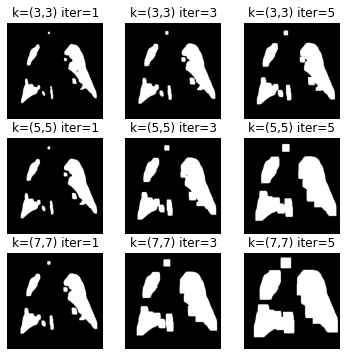

In [0]:
# IMG_IDX = np.random.choice(a=len(X), size=None)
IMG_IDX = 413
print('image index:', IMG_IDX)
test_img = np.expand_dims(X[IMG_IDX], axis=0)
test_img_sq = test_img.squeeze()

test_img_ahe = np.expand_dims(rank.equalize(test_img_sq, selem=disk(40)), axis=-1)
roi_ahe = segmentor(np.expand_dims(test_img_ahe, axis=0))
roi_ahe_sq = np.squeeze(roi_ahe)


grid = [(3, 1), (3, 3), (3, 5),
        (5, 1), (5, 3), (5, 5),
        (7, 1), (7, 3), (7, 5)]

fig = plt.figure(num=9, figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    kernel = np.ones((grid[i][0], grid[i][0]))
    roi_dilated = cv2.dilate(roi_ahe_sq, kernel=kernel, iterations=grid[i][1])
    plt.imshow(roi_dilated, cmap='gray')
    plt.title('k=(%d,%d) iter=%d' % (grid[i][0], grid[i][0], grid[i][1]))
    plt.axis('off')
print('How much dilation do we need?')
plt.show()

image index: 119


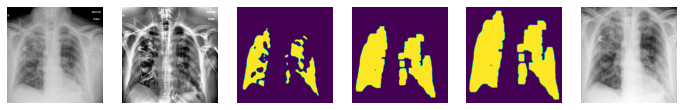

In [41]:
IMG_IDX = np.random.choice(a=len(X), size=None)
# IMG_IDX = 119
print('image index:', IMG_IDX)
test_img = np.expand_dims(X[IMG_IDX], axis=0)
test_img_sq = test_img.squeeze()
test_img_ahe = np.expand_dims(rank.equalize(test_img_sq, selem=disk(40)), axis=-1)
roi_ahe = segmentor(np.expand_dims(test_img_ahe, axis=0))
roi_ahe_sq = np.squeeze(roi_ahe)
kernel = np.ones((5, 5))
roi_dilated = cv2.dilate(roi_ahe_sq, kernel=kernel, iterations=3)

mask_y, mask_x = np.where(roi_dilated==1)
MARGIN = 10
start_x = np.min(mask_x) - MARGIN
end_x = np.max(mask_x) + MARGIN
start_y = np.min(mask_y) - MARGIN
end_y = np.max(mask_y) + MARGIN

fig = plt.figure(num=6, figsize=(12, 2))
plt.subplot(1, 6, 1)
plt.imshow(test_img_sq, cmap='gray')
plt.axis('off')
plt.subplot(1, 6, 2)
plt.imshow(test_img_ahe.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 6, 3)
plt.imshow(roi_ahe_sq)
plt.axis('off')
plt.subplot(1, 6, 4)
plt.imshow(roi_dilated)
plt.axis('off')
plt.subplot(1, 6, 5)
roi_cropped = roi_dilated[start_y:end_y, start_x:end_x]
roi_cropped_resized = cv2.resize(roi_cropped, dsize=(320, 320))
plt.imshow(roi_cropped_resized)
plt.axis('off')
plt.subplot(1, 6, 6)
cropped_img = test_img_sq[start_y:end_y, start_x:end_x]
cropped_img_resized = cv2.resize(cropped_img, dsize=(320, 320))
plt.imshow(cropped_img_resized, cmap='gray')
plt.axis('off')
plt.show()